In [12]:
# Read data from the driving_log.csv file
import csv

lines = []
with open('../../data/simulator/track1-run1-pretty-centered/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
print("No. of lines read from CSV-file: {}".format(len(lines)))

No. of lines read from CSV-file: 1344


In [13]:
# Config parameters
dict_config_params = {}
dict_config_params['angle_correction'] = 0.2

In [14]:
# Populate training data
# Do data augmentation by flipping images vertically

import numpy as np
import cv2
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# TODO May not function correctly as is.
def generator(samples, batch_size=32):
    
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = '../../data/simulator/track1-run1-pretty-centered/IMG/'
                name_center = name + batch_sample[0].split('/')[-1]
                name_left = name + batch_sample[1].split('/')[-1]
                name_right = name + batch_sample[2].split('/')[-1]
                
                # center_image = cv2.imread(name)
                center_image = cv2.cvtColor(cv2.imread(name_center), cv2.COLOR_BGR2RGB)
                left_image = cv2.cvtColor(cv2.imread(name_left), cv2.COLOR_BGR2RGB)
                right_image = cv2.cvtColor(cv2.imread(name_right), cv2.COLOR_BGR2RGB)
                
                # create adjusted steering measurements for the side camera images
                center_angle = float(batch_sample[3])
                left_angle = center_angle + dict_config_params['angle_correction']
                right_angle = center_angle - dict_config_params['angle_correction']
                
                images.extend((center_image, left_image, right_image))
                angles.extend((center_angle, left_angle, right_angle))

            X = np.array(images)
            y = np.array(angles)
            
            # print("X-shape: {}".format(X.shape))
            # print("y-shape: {}".format(y.shape))
            yield sklearn.utils.shuffle(X, y)
            
# Generator functions
train_samples, validation_samples = train_test_split(lines, test_size=0.2)
train_generator = generator(train_samples, batch_size=8) # batch_size=32
validation_generator = generator(validation_samples, batch_size=8) # batch_size=32

# Generators debugging
X_debug_gen, y_debug_gen =next(train_generator)
print("generator image shape = {}".format(X_debug_gen[0].shape))
print("X_debug_gen shape = {}".format(X_debug_gen.shape))
print("y_debug_gen shape = {}".format(y_debug_gen.shape))
print()

def load_data(lines):
    images = []
    measurements = []

    iter_lines = iter(lines)
    next(iter_lines)
    for line in iter_lines:
        img_filename = line[0]	# center-camera
        img_filename = img_filename.split('/')[-1]

        #source_path = '../../data/simulator/sim-drive-data-udacity/IMG'
        source_path = '../../data/simulator/track1-run1-pretty-centered/IMG/'
        source_path += img_filename
        image = cv2.cvtColor(cv2.imread(source_path), cv2.COLOR_BGR2RGB) #cv2.imread(source_path)

        images.append(image)

        # Augmenting with vertically flipped image to balance the dataset skew towards leftward
        # steering angles. With the original training data, the car keeps going in anticlockwise
        # circles! 
        flipped_image=image.copy()
        flipped_image=cv2.flip(image,1)
        images.append(flipped_image)

        measurement = float(line[3])
        measurements.append(measurement)
        measurements.append(-measurement) # steering angle corr. to flipped image

    X_train = np.array(images)
    y_train = np.array(measurements)
    return X_train, y_train
    
X_train, y_train = load_data(lines)
print("image shape = {}".format(X_train[0].shape))
print("X_train shape = {}".format(X_train.shape))
print("y_train shape = {}".format(y_train.shape))

generator image shape = (160, 320, 3)
X_debug_gen shape = (24, 160, 320, 3)
y_debug_gen shape = (24,)

image shape = (160, 320, 3)
X_train shape = (2686, 160, 320, 3)
y_train shape = (2686,)


Go to <a href=#bookmark>my bookmark</a>

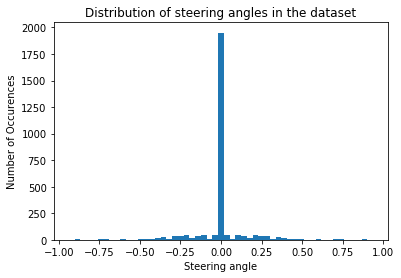

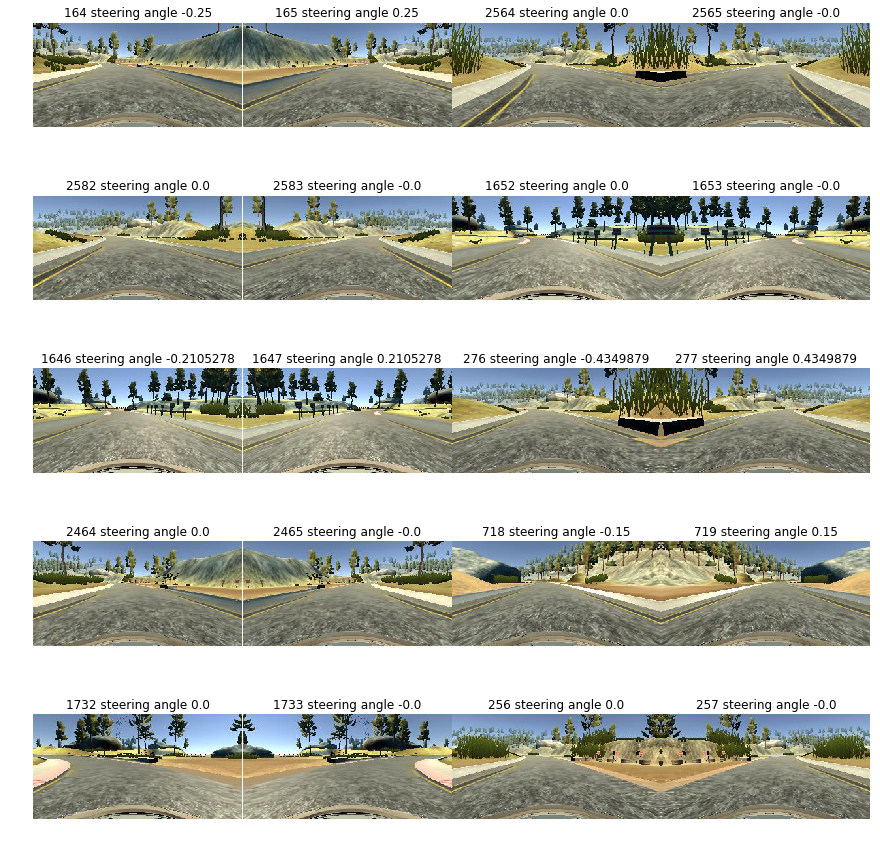

In [15]:
### Data exploration visualization code
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# Visualizations will be shown in the notebook.
get_ipython().run_line_magic('matplotlib', 'inline')


def visualize_images(X, y, num_random_imgs=10, color_map=None):
    random.seed(3242)
    
    fig, axs = plt.subplots(int(num_random_imgs/4), 4, figsize=(15, 15))
    fig.subplots_adjust(hspace = .4, wspace=.003)
    axs = axs.ravel()
    for i in range(0, num_random_imgs, 2):
        index = random.randint(0, len(X))
        if index%2!=0:
            index+=1 # We want an even index
        
        if color_map=='gray':
            image = X[index].squeeze()
            image_flipped = X[index+1].squeeze()
        else:
            image = X[index]
            image_flipped = X[index+1]
            #print("image shape = {}".format(image_flipped.shape))
                
        axs[i].axis('off')
        axs[i].imshow(image, color_map)
        axs[i].set_title("{} steering angle {}".format(index, y[index]))
        
        axs[i+1].axis('off')
        axs[i+1].imshow(image_flipped, color_map)
        axs[i+1].set_title("{} steering angle {}".format(index+1, y[index+1]))

def plot_histogram(data):
    plt.hist(data, bins=int(2*len(data)/100))
    # plt.xlim(xmax=n_classes-1)
    plt.ylabel('Number of Occurences')
    plt.xlabel('Steering angle')
    plt.title('Distribution of steering angles in the dataset')
        
# print("y_train = {}".format(y_train[360:380]))
plot_histogram(y_train)
visualize_images(X_train, y_train, num_random_imgs=20)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_5 (Cropping2D)        (None, 80, 320, 3)    0           cropping2d_input_5[0][0]         
____________________________________________________________________________________________________
lambda_5 (Lambda)                (None, 80, 320, 3)    0           cropping2d_5[0][0]               
____________________________________________________________________________________________________
convolution2d_21 (Convolution2D) (None, 76, 316, 6)    456         lambda_5[0][0]                   
____________________________________________________________________________________________________
activation_33 (Activation)       (None, 76, 316, 6)    0           convolution2d_21[0][0]           
___________________________________________________________________________________________

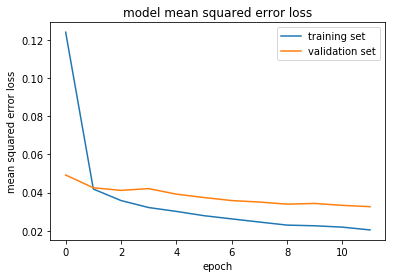

In [17]:
from model import configure_tensorflow_session, get_model_single_layer, \
                  get_model_single_layer_cropped, get_model_lenet, \
                  get_model_nvidia_arch

configure_tensorflow_session()

# model = get_model_single_layer()
# model = get_model_single_layer_cropped()
model = get_model_lenet()
# model = get_model_nvidia_arch()

model.summary()

model.compile(loss='mse', optimizer='adam')

# X_train, y_train = shuffle(np.array(images), np.array(measurements)) 
# history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle='True', nb_epoch=12)

history_object = model.fit_generator(train_generator, samples_per_epoch= len(3*train_samples), 
                    validation_data=validation_generator, nb_val_samples=len(3*validation_samples), 
                    nb_epoch=12)

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model.h5')